# Recommender system for books: Cleaning and exploration

- Utils

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np
import missingno as msno

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# system libraries
import gc
import glob
import sys
sys.path.append("Modules/")

# nlp preprocessing module
import nlp_module as nlp

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# seaborn parameters
sns.set_theme(style="ticks",
              palette="Pastel2")

Before doing modelisation, datasets will be explored. Our data are presented in two datasets : 
- One about books
- One about users
The datasets were created by extracting information for Goodreads API. This API is desactivated since December 2020. Our data present information from 2013 to 2019. 

## 1) Exploring the books datasets

In [3]:
# importing different files and 
# concatenating in one dataset
filepath = 'Datasets/'

all_files = glob.glob(filepath + "books/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

merged_books = pd.concat(li,
                        axis=0,
                        ignore_index=True)
merged_books.head()

,Id,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,...,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,PagesNumber,Description,pagesNumber,Count of text reviews
0,4000000,Top Management,Bernard Taylor,0582446058,0.00,1973,1,1,Longman Publishing Group,5:0,...,3:0,2:0,1:0,total:0,0,NaN,448.0,NaN,NaN,NaN
1,4000001,"Celtic Warfare, 1595 1763",James Michael Hill,0859761517,3.67,1986,1,1,J. Donald,5:1,...,3:0,2:1,1:0,total:3,0,NaN,203.0,NaN,NaN,NaN
2,4000002,Playwright Power,Robert Friedman,0761803629,0.00,1996,7,28,University Press of America,5:0,...,3:0,2:0,1:0,total:0,0,NaN,164.0,Playwright Power is a concise handbook on how ...,NaN,NaN
3,4000009,Selected Topics In Harmonic Maps,James Eells,0821807005,0.00,1983,1,1,American Mathematical Society(RI),5:0,...,3:0,2:0,1:0,total:0,0,NaN,85.0,Gives an account of the various aspects of the...,NaN,NaN
4,4000010,Foreign Exchange Intervention: Objectives And ...,Sylvester C.W. Eijffinger,1858988128,0.00,1999,1,1,Edward Elgar Publishing,5:0,...,3:0,2:0,1:0,total:0,0,NaN,608.0,This collection of previously published articl...,NaN,NaN


As seen below, this dataset contains 21 columns. For each book, we have : 
- An Id, which is an artificial data created for database; 
- A name, which correspond to the title of the books;
- Authors;
- The ISBN, for more information about the ISBN (https://en.wikipedia.org/wiki/International_Standard_Book_Number);
- Ratings, which correspond to the average rating for the book;
- Informations about the date of publication;
- Publisher;
- Rating distance, which corresponds to the number of ratings for each score from 1 to 5;
- Counts of review, which is the number of text reviews;
- Language;
- Number of pages;
- Description.

<AxesSubplot:>

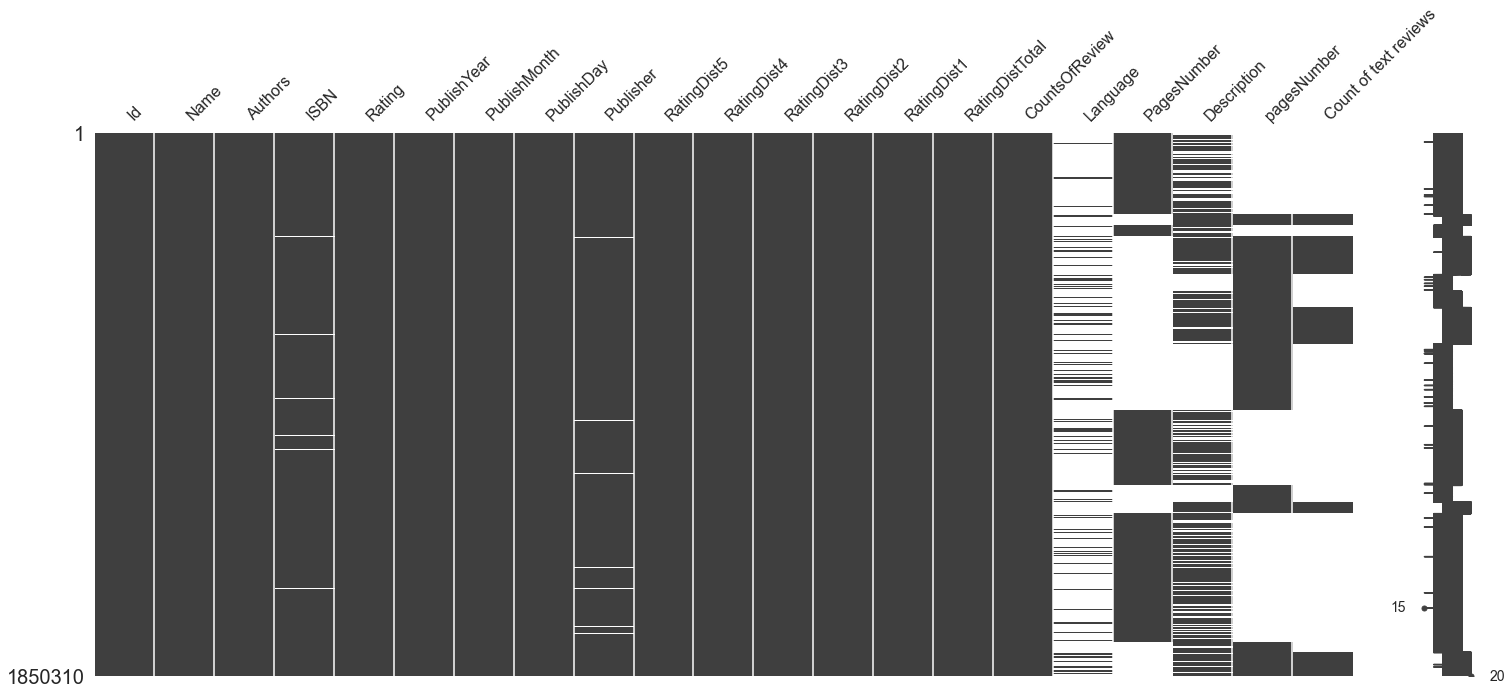

In [4]:
# Identify missing values
msno.matrix(merged_books)

In [5]:
merged_books["NumberOfPages"] = merged_books["PagesNumber"].fillna(0)\
                              + merged_books["pagesNumber"].fillna(0)

In [6]:
# deleting columns about publish day, month and ratingdists
merged_books.drop(["PublishMonth", "PublishDay",
                   "RatingDist5", "RatingDist4",
                   "RatingDist3", "RatingDist3",
                   "RatingDist2", "RatingDist1",
                   "CountsOfReview", "Count of text reviews",
                   "PagesNumber", "pagesNumber"], axis=1,
                   inplace=True)

In [7]:
merged_books["RatingDistTotal"] = merged_books["RatingDistTotal"].str.replace('total:', '')
merged_books["RatingDistTotal"] = merged_books["RatingDistTotal"].astype("int")

In [8]:
merged_books.head()

,Id,Name,Authors,ISBN,Rating,PublishYear,Publisher,RatingDistTotal,Language,Description,NumberOfPages
0,4000000,Top Management,Bernard Taylor,0582446058,0.00,1973,Longman Publishing Group,0,NaN,NaN,448.0
1,4000001,"Celtic Warfare, 1595 1763",James Michael Hill,0859761517,3.67,1986,J. Donald,3,NaN,NaN,203.0
2,4000002,Playwright Power,Robert Friedman,0761803629,0.00,1996,University Press of America,0,NaN,Playwright Power is a concise handbook on how ...,164.0
3,4000009,Selected Topics In Harmonic Maps,James Eells,0821807005,0.00,1983,American Mathematical Society(RI),0,NaN,Gives an account of the various aspects of the...,85.0
4,4000010,Foreign Exchange Intervention: Objectives And ...,Sylvester C.W. Eijffinger,1858988128,0.00,1999,Edward Elgar Publishing,0,NaN,This collection of previously published articl...,608.0


In [9]:
merged_books.dropna(inplace=True)

<AxesSubplot:>

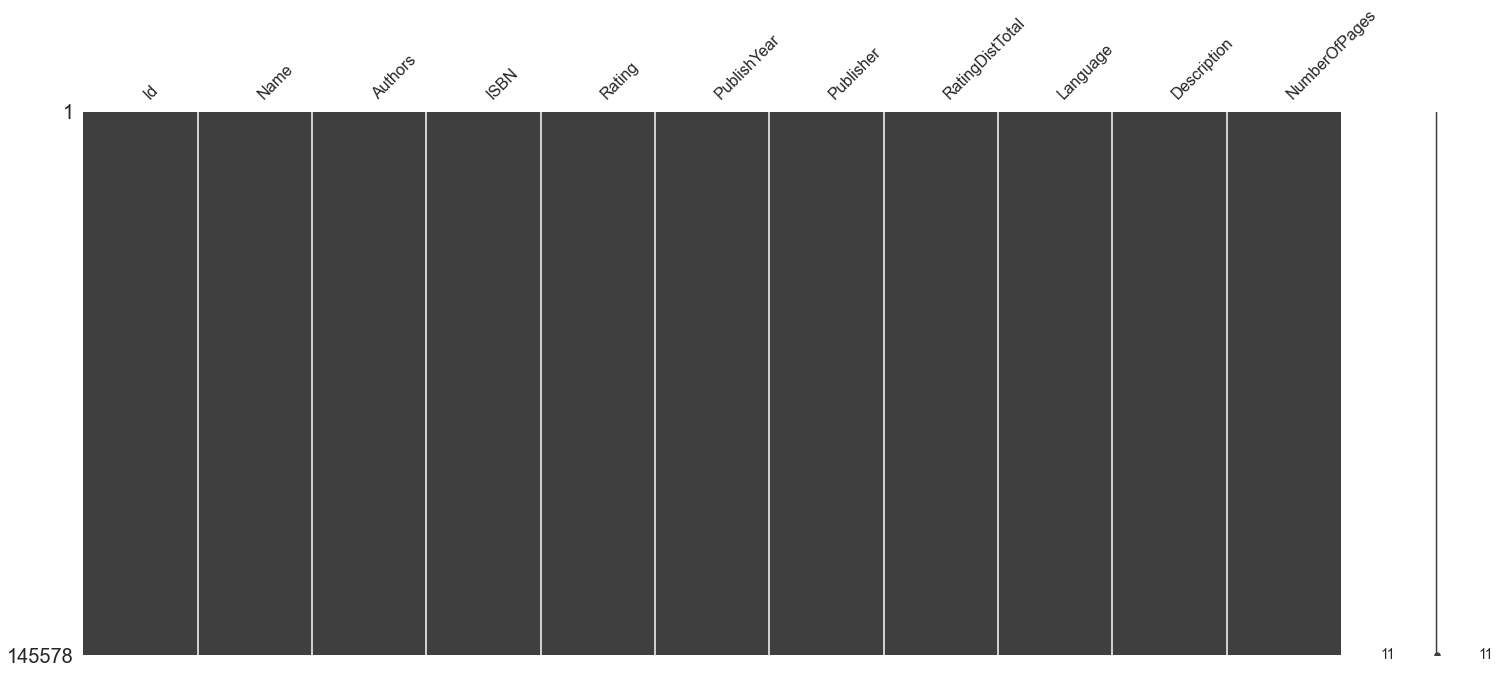

In [10]:
msno.matrix(merged_books)

In [11]:
merged_books.shape

(145578, 11)

In [12]:
merged_books.isnull().mean() * 100

Id                 0.0
Name               0.0
Authors            0.0
ISBN               0.0
Rating             0.0
PublishYear        0.0
Publisher          0.0
RatingDistTotal    0.0
Language           0.0
Description        0.0
NumberOfPages      0.0
dtype: float64

### a) Numerical variables

In this part, we explore informations about numerical variables. These variables are the year of publication, the average ratings of each books, the number of ratings, the number of pages and the number of reviews.

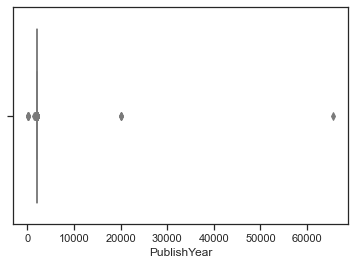

In [13]:
sns.boxplot(x="PublishYear",
            data=merged_books)
plt.show()

In [14]:
# dropping data where year of publication is 
# less than 1820 & more than 2019
ind = merged_books.loc[(merged_books["PublishYear"] <= 1820)\
                       | (merged_books["PublishYear"] >= 2019)].index\
                       .to_list()
merged_books.drop(index=ind,
                  inplace=True)

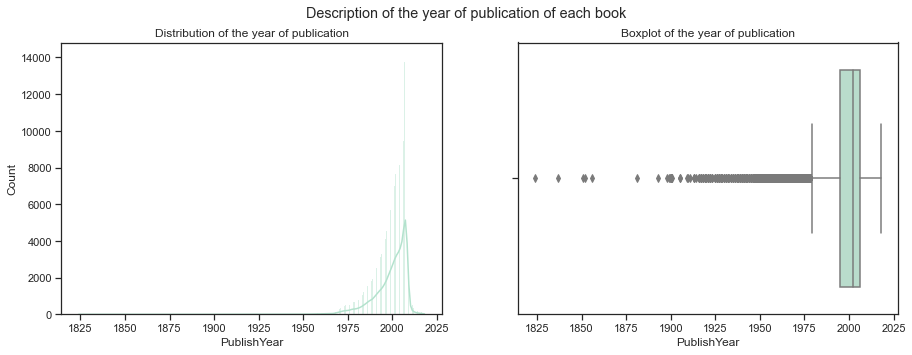

In [15]:
fig, axes = plt.subplots(1, 2,
                         figsize=(15, 5),
                         sharex=True)
fig.suptitle('Description of the year of publication of each book')

sns.histplot(ax=axes[0],
             x="PublishYear",
             data=merged_books,
             kde=True)
axes[0].set_title("Distribution of the year of publication")

sns.boxplot(ax=axes[1],
            x="PublishYear",
            data=merged_books)
axes[1].set_title("Boxplot of the year of publication")

plt.show()

After cleaning, only books with a year of publication between 1820 and 2019 were conserved. The majority of the books had been published between 1980 and 2019. The average is around 2000. 

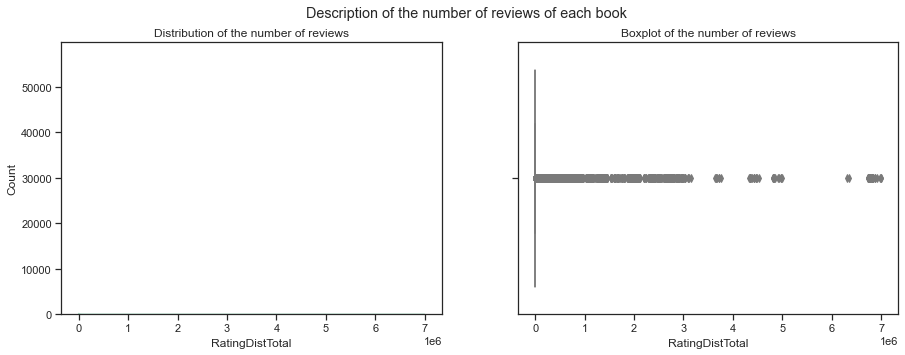

In [16]:
fig, axes = plt.subplots(1, 2,
                         figsize=(15, 5),
                         sharex=True)
fig.suptitle('Description of the number of reviews of each book')

sns.histplot(ax=axes[0],
             x="RatingDistTotal",
             data=merged_books, kde=True)
axes[0].set_title("Distribution of the number of reviews")

sns.boxplot(ax=axes[1],
            x="RatingDistTotal",
            data=merged_books)
axes[1].set_title("Boxplot of the number of reviews")

plt.show()

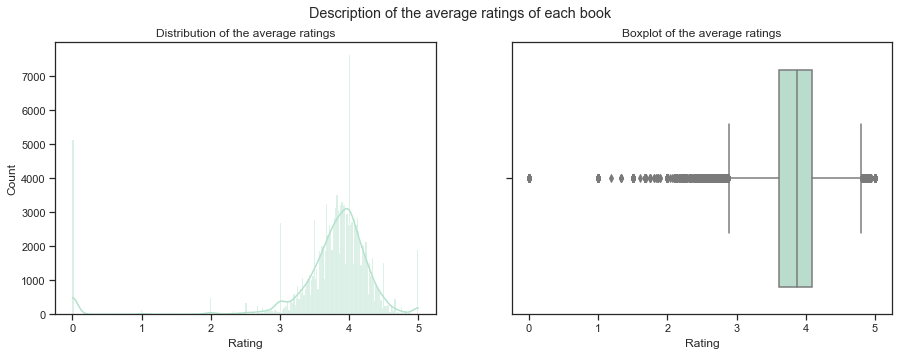

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description of the average ratings of each book')

sns.histplot(ax=axes[0],
             x="Rating",
             data=merged_books,
             kde=True)
axes[0].set_title("Distribution of the average ratings")

sns.boxplot(ax=axes[1],
            x="Rating",
            data=merged_books)
axes[1].set_title("Boxplot of the average ratings")

plt.show()

### b) Categorical variables

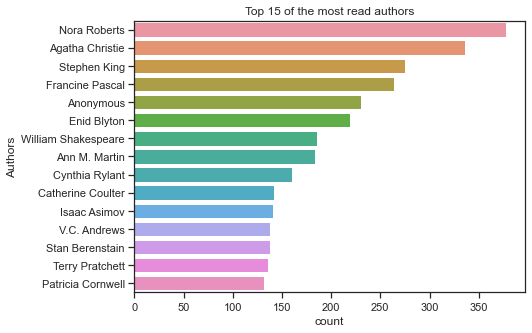

In [18]:
plt.figure(figsize=(7, 5))

sns.countplot(y="Authors",
              data=merged_books,
              order=merged_books["Authors"]\
              .value_counts()\
              .index[:15])

plt.title("Top 15 of the most read authors")
plt.show()

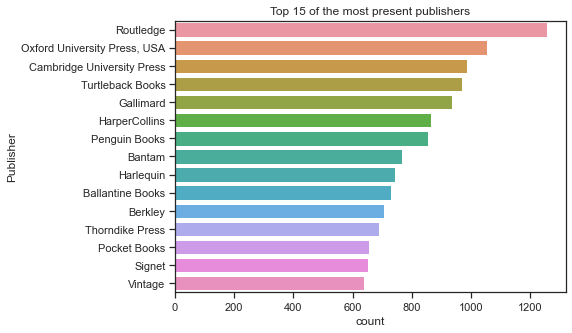

In [19]:
plt.figure(figsize=(7, 5))

sns.countplot(y="Publisher",
              data=merged_books,
              order=merged_books["Publisher"]\
              .value_counts()\
              .index[:15])

plt.title("Top 15 of the most present publishers")
plt.show()

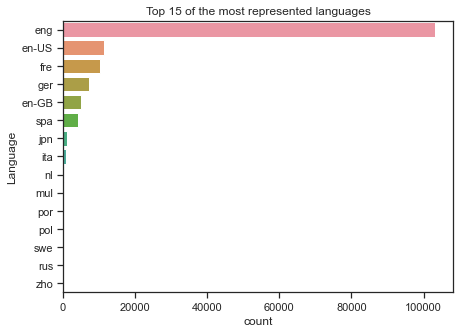

In [20]:
plt.figure(figsize=(7, 5))

sns.countplot(y="Language",
              data=merged_books,
              order=merged_books["Language"]\
              .value_counts()\
              .index[:15])
plt.title("Top 15 of the most represented languages")
plt.show()

In [21]:
lang = {
    "en-US" : "eng",
    "en-GB" : "eng",
    "en-CA" : "eng"
}

In [22]:
for key, value in lang.items():
    merged_books["Language"]\
    .loc[merged_books["Language"]\
    .str.contains(key, 
                  case=False,
                  regex=False)] = value

/home/cecile/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


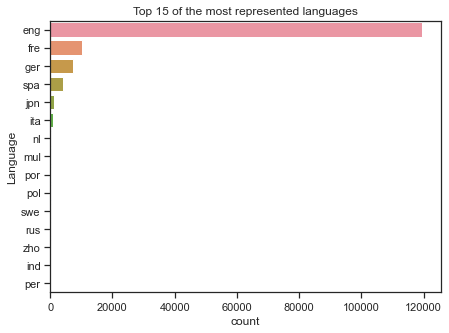

In [23]:
plt.figure(figsize=(7, 5))

sns.countplot(y="Language",
              data=merged_books,
              order=merged_books["Language"]\
              .value_counts()\
              .index[:15])
              
plt.title("Top 15 of the most represented languages")
plt.show()

In [24]:
merged_books_en = merged_books[merged_books["Language"] == "eng"]
merged_books_en.head()

,Id,Name,Authors,ISBN,Rating,PublishYear,Publisher,RatingDistTotal,Language,Description,NumberOfPages
21,4000063,The Flintstones in Viva Rock Vegas,Ellen Miles,0439173035,3.82,2000,Scholastic Inc.,11,eng,Spring 2000 marks the release of the new Flint...,136.0
36,4000100,Little Rhody,Neta Lohnes Frazier,0679250808,4.33,2000,David McKay Company,9,eng,A spunky ten-year-old girl moves with her fami...,152.0
83,4000228,Finance And Investments Using The Wall Street ...,Peter R. Crabb,0072829362,0.00,2002,Irwin/McGraw-Hill,0,eng,Peter Crabb's The Wall Street Journal Workbook...,402.0
138,4000366,Shorty McCabe Looks 'Em Over,Sewell Ford,0836935357,0.00,1970,Books for Libraries,0,eng,This is an EXACT reproduction of a book publis...,344.0
168,4000441,Plant Pathology,George N. Agrios,0120445646,4.52,1997,Academic Press,84,eng,"This is a classic textbook on plant diseases, ...",635.0


### c) Description of books analysis

In [25]:
desc = merged_books_en[["Id", "Description"]]
desc.head(3)

,Id,Description
21,4000063,Spring 2000 marks the release of the new Flint...
36,4000100,A spunky ten-year-old girl moves with her fami...
83,4000228,Peter Crabb's The Wall Street Journal Workbook...


In [26]:
desc["Description"] = nlp.normalize_corpus(desc["Description"])

/home/cecile/anaconda3/envs/nlpenv/lib/python3.9/site-packages/bs4/__init__.py:337: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/cecile/anaconda3/envs/nlpenv/lib/python3.9/site-packages/bs4/__init__.py:337: MarkupResemblesLocatorWarning: ".." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(
/tmp/ipykernel_8937/3132403736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc["Description"] = nlp.normalize_corpus(desc["Description"])


In [27]:
desc.head(3)

,Id,Description
21,4000063,spring mark release new flintstone film flints...
36,4000100,spunky ten year old girl move family farm invo...
83,4000228,peter crabbs wall street journal workbook inve...


In [28]:
desc.to_csv("Datasets/description.csv")
desc.to_parquet("Datasets/description.parquet.gzip",
                compression="gzip",
                index=False)

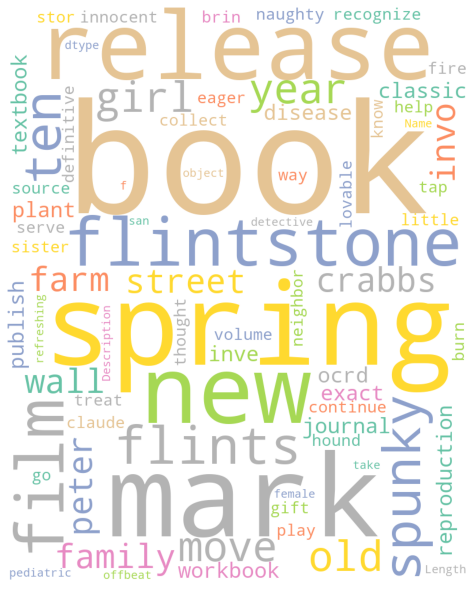

In [29]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 12,
                colormap="Set2").generate(str(desc["Description"]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8),
           facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [30]:
merged_books_en.drop("Description",
                     axis=1,
                     inplace=True)
data = pd.merge(merged_books_en,
                desc,
                on="Id")
data.head(3)

/home/cecile/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Id,Name,Authors,ISBN,Rating,PublishYear,Publisher,RatingDistTotal,Language,NumberOfPages,Description
0,4000063,The Flintstones in Viva Rock Vegas,Ellen Miles,0439173035,3.82,2000,Scholastic Inc.,11,eng,136.0,spring mark release new flintstone film flints...
1,4000100,Little Rhody,Neta Lohnes Frazier,0679250808,4.33,2000,David McKay Company,9,eng,152.0,spunky ten year old girl move family farm invo...
2,4000228,Finance And Investments Using The Wall Street ...,Peter R. Crabb,0072829362,0.00,2002,Irwin/McGraw-Hill,0,eng,402.0,peter crabbs wall street journal workbook inve...


In [31]:
data.drop("Language",
           axis=1,
           inplace=True)

In [32]:
data.to_parquet("Datasets/books_data_cleaning.parquet.gzip",
                 compression="gzip",
                 index=False)

In [33]:
del data,\
    merged_books,\
    merged_books_en
gc.collect()

8143123

## 2) Exploring the users datasets

In [34]:
book_data = pd.read_parquet("Datasets/books_data_cleaning.parquet.gzip")

In [35]:
# importing different files and 
# concatenating in one dataset
filepath = 'Datasets/'

all_files = glob.glob(filepath\
          + "users_ratings/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

merged_users = pd.concat(li,
                         axis=0,
                         ignore_index=True)
merged_users.head()

,ID,Name,Rating
0,5410,Rating,This user doesn't have any rating
1,5411,Rating,This user doesn't have any rating
2,5412,Rating,This user doesn't have any rating
3,5416,Rating,This user doesn't have any rating
4,5417,Rating,This user doesn't have any rating


<AxesSubplot:>

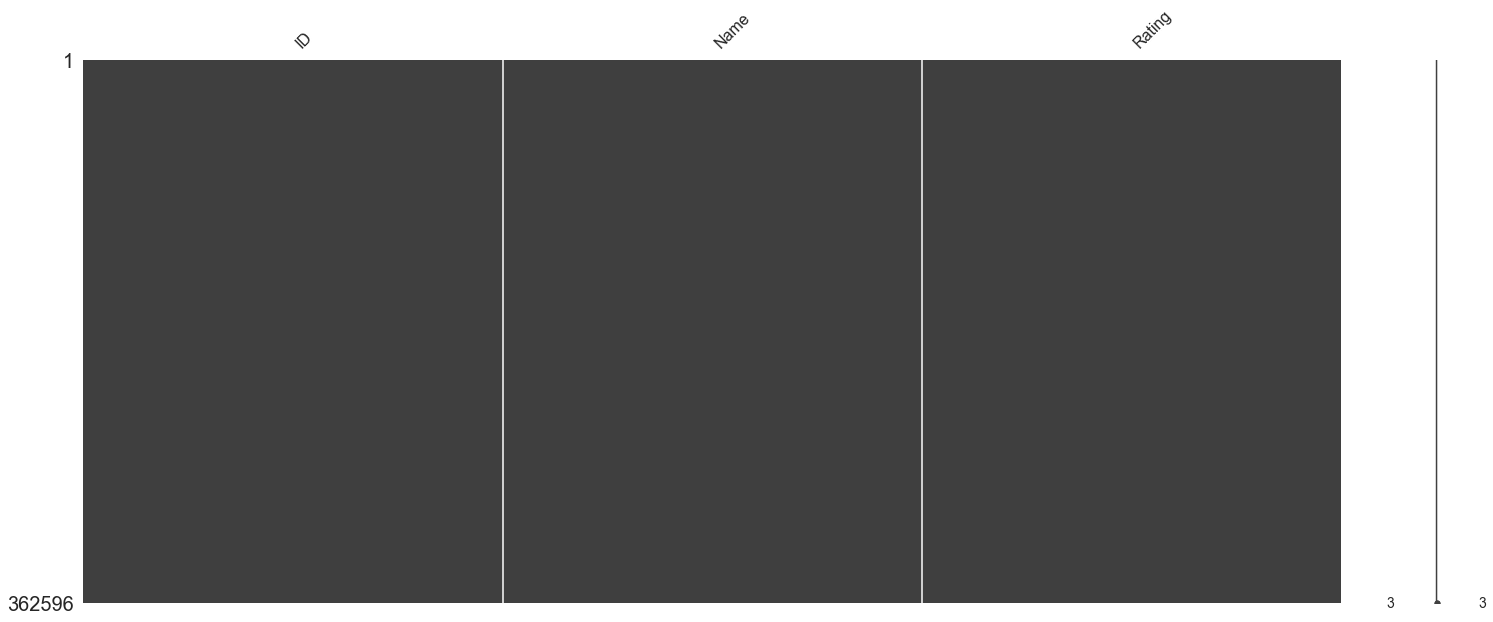

In [36]:
# Identify missing values
msno.matrix(merged_users)

In [37]:
merged_users["Rating"].unique()

array(["This user doesn't have any rating", 'really liked it', 'liked it',
       'it was amazing', 'it was ok', 'did not like it'], dtype=object)

In [38]:
new_ratings ={
    "This user doesn't have any rating" : np.nan,
    "did not like it" : 1,
    "it was ok" : 2,
    "liked it" : 3,
    "really liked it" : 4,
    "it was amazing" : 5
}

merged_users["Rating"] = merged_users["Rating"].map(new_ratings)

In [39]:
merged_users.columns = ['User_Id', "Name", "Rating"]

<AxesSubplot:>

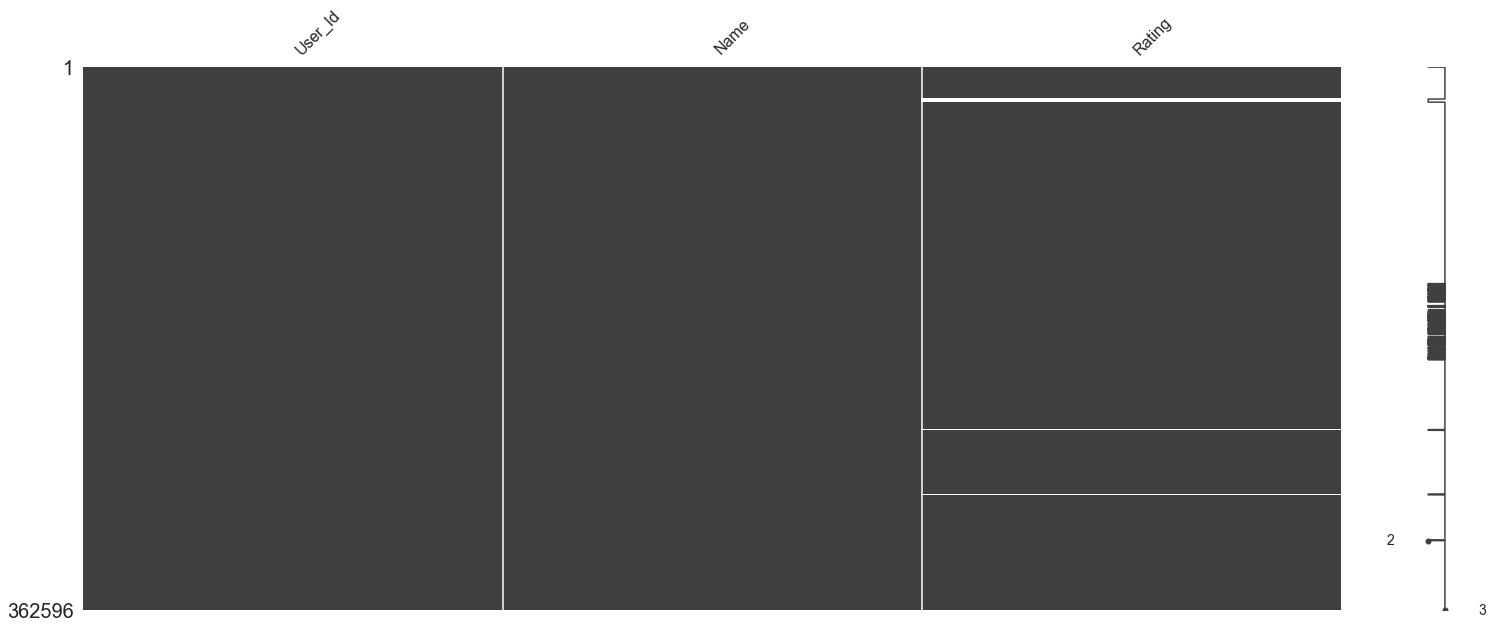

In [40]:
# Identify missing values
msno.matrix(merged_users)

In [41]:
merged_users.dropna(inplace=True)

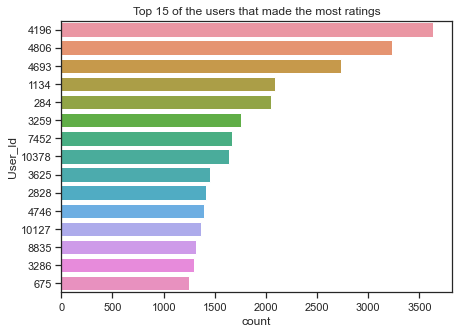

In [42]:
plt.figure(figsize=(7, 5))

sns.countplot(y="User_Id",
              data=merged_users,
              order=merged_users["User_Id"].value_counts().index[:15])
plt.ylabel("User Id")
plt.title("Top 15 of the users that made the most ratings")
plt.show()

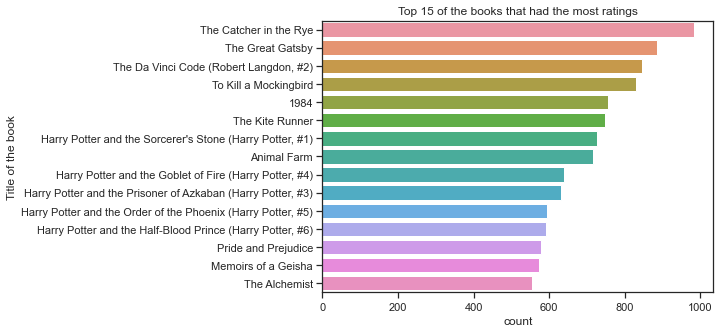

In [43]:
plt.figure(figsize=(7, 5))

sns.countplot(y="Name",
              data=merged_users,
              order=merged_users["Name"].value_counts().index[:15])
plt.ylabel("Title of the book")
plt.title("Top 15 of the books that had the most ratings")
plt.show()

In [44]:
book_data = book_data[["Id","Name", "Authors"]]

In [45]:
rating_merged = pd.merge(merged_users,
                         book_data,
                         on = "Name")
rating_merged.head()

,User_Id,Name,Rating,Id,Authors
0,5433,Of Mice and Men,4.0,810433,John Steinbeck
1,5473,Of Mice and Men,4.0,810433,John Steinbeck
2,5491,Of Mice and Men,3.0,810433,John Steinbeck
3,5499,Of Mice and Men,3.0,810433,John Steinbeck
4,5527,Of Mice and Men,3.0,810433,John Steinbeck


In [46]:
rating_merged.drop(["Name", "Authors"],
                    axis=1, 
                    inplace=True, )

In [47]:
rating_merged.to_parquet("Datasets/users_data_cleaning.parquet.gzip",
                compression="gzip",
                index=False)